<a href="https://colab.research.google.com/github/1972007/ml-c22-pc390/blob/main/C22_PC390.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Skin Disease Detection

Kaggle Preps

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q kaggle
! mkdir ~/.kaggle

In [ ]:
!pip install isic-cli


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement isic-cli (from versions: none)
ERROR: No matching distribution found for isic-cli


In [ ]:
#Yang lain
from google.colab import files
json_kaggle = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:

! cp kaggle.json ~/.kaggle/

Dataset downloads

In [ ]:
#! kaggle datasets download shubhamgoel27/dermnet
# Ide dataset : https://www.kaggle.com/datasets/ammarabbasi1040/skin-diseases-dataset
#! kaggle datasets download ismailpromus/skin-diseases-image-dataset
#! kaggle datasets download ammarabbasi1040/skin-diseases-dataset
!wget https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Test_Input.zip

In [ ]:
!wget https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Training_Input.zip

In [ ]:
!wget https://rserve.dataverse.harvard.edu/cgi-bin/zipdownload?258-b35aa5703b95

In [ ]:
!wget https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Training_Metadata.csv

In [ ]:
def unzip(local_zip,dest_zip):
  zip_ref = zipfile.ZipFile(local_zip, 'r')
  zip_ref.extractall(dest_zip)
  zip_ref.close()

In [ ]:
import zipfile
local_zip = "/content/drive/MyDrive/C22-PC390/dataverse_files.zip"
dest_zip = "/content/drive/MyDrive/C22-PC390/dataverse_files"
unzip(local_zip,dest_zip)

In [ ]:
# file_to_unzip = ["/content/drive/MyDrive/C22-PC390/dataverse_files/HAM10000_images_part_1.zip",
#                 "/content/drive/MyDrive/C22-PC390/dataverse_files/HAM10000_images_part_2.zip"]
file_to_unzip = ["/content/drive/MyDrive/C22-PC390/dataverse_files/HAM10000_segmentations_lesion_tschandl.zip",
                 "/content/drive/MyDrive/C22-PC390/dataverse_files/ISIC2018_Task3_Test_Images.zip",
                 "/content/drive/MyDrive/C22-PC390/dataverse_files/ISIC2018_Task3_Validation_Input.zip"]

for i in file_to_unzip:
  unzip(i,i[:-4])                

In [ ]:
%mv /content/drive/MyDrive/C22-PC390/dataverse_files/HAM10000_images_part_2/* /content/drive/MyDrive/C22-PC390/dataverse_files/HAM10000_images_part_1

In [ ]:
import zipfile
#local_zip = "/content/dermnet.zip"
#dest_zip = "/content/dermnet"
local_zip = "/content/skin-diseases-image-dataset.zip"
dest_zip = "/content/skin-diseases-image-dataset"
#local_zip = "/content/skin-diseases-dataset.zip"
#dest_zip = "/content/skin-diseases-dataset"
local_zip = "/content/ISIC_2019_Training_Input.zip"
dest_zip = "/content/drive/MyDrive/C22-PC390/ISIC_2019_Training_Input"


Now to load the dataset

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import random
import os
import shutil
import numpy as np
import pandas as pd

In [ ]:
def append_ext(file):
  return file + ".jpg"

In [ ]:
traindf = pd.read_csv("/content/drive/MyDrive/C22-PC390/dataverse_files/HAM10000_metadata")
validdf = pd.read_csv("/content/drive/MyDrive/C22-PC390/dataverse_files/test_ham10000valid2018.csv")
traindf["image_id"] = traindf["image_id"].apply(append_ext)
validdf["image"] = validdf["image"].apply(append_ext)
validdf["dx"] = validdf["dx"].apply(lambda x:x.lower())

In [ ]:
traindf.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419.jpg,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030.jpg,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769.jpg,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661.jpg,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633.jpg,bkl,histo,75.0,male,ear,vidir_modern


In [ ]:
validdf.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,dx
0,ISIC_0034321.jpg,0,10,0,0,0,0,0,nv
1,ISIC_0034322.jpg,0,10,0,0,0,0,0,nv
2,ISIC_0034323.jpg,0,0,10,0,0,0,0,bcc
3,ISIC_0034324.jpg,0,10,0,0,0,0,0,nv
4,ISIC_0034325.jpg,0,10,0,0,0,0,0,nv


ISIC_0032473 nv


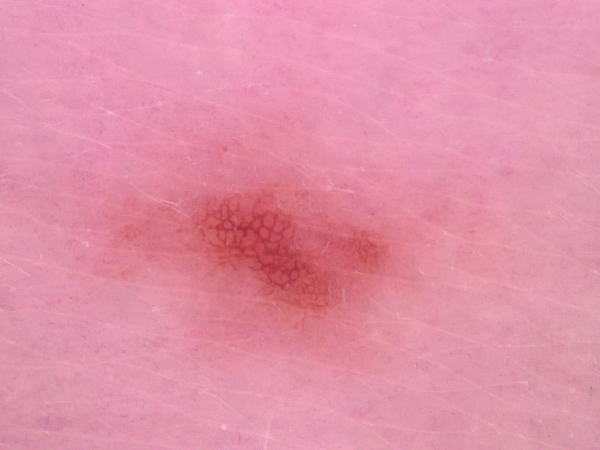

In [ ]:
idx = 5000
print(traindf["image_id"][idx], traindf["dx"][idx])
im = Image.open("/content/drive/MyDrive/C22-PC390/dataverse_files/HAM10000_images_part_1/"+traindf["image_id"][idx]+".jpg")
im

ISIC_0028681 bkl


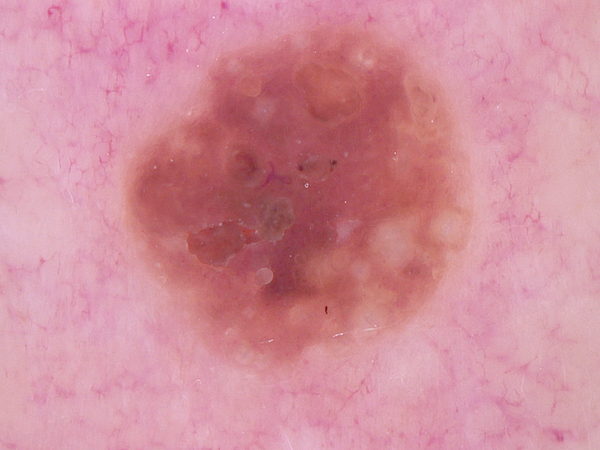

In [ ]:

print(traindf["image_id"][idx], traindf["dx"][idx])
im = Image.open("/content/drive/MyDrive/C22-PC390/dataverse_files/HAM10000_images_part_1/"+traindf["image_id"][idx+1]+".jpg")
im

In [ ]:
img_dir_example = "/content/drive/MyDrive/C22-PC390/dataverse_files/HAM10000_images_part_1/ISIC_0024306.jpg"
im = Image.open(img_dir_example)
img_size = im.size
print(img_size)

(600, 450)


In [ ]:
from sklearn.model_selection import train_test_split
split_rate = 0.9
src_train = "/content/drive/MyDrive/C22-PC390/dataverse_files/HAM10000_images_part_1"
src_valid = "/content/drive/MyDrive/C22-PC390/dataverse_files/ISIC2018_Task3_Validation_Input/ISIC2018_Task3_Validation_Input"
# x_valid, x_test, y_valid, y_test = train_test_split(validdf["image"],validdf["dx"],test_size=1-split_rate)
# x_valid.head(), y_valid.head()

In [ ]:
class_mode = "sparse"
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_gen = train_datagen.flow_from_dataframe(directory=src_train,
                                              dataframe = traindf,
                                              x_col= "image_id",
                                              y_col= "dx",
                                              batch_size=128,
                                              class_mode=class_mode,
                                              target_size=img_size)

valid_datagen = ImageDataGenerator(rescale=1/255.0, validation_split=0.2)
valid_gen = valid_datagen.flow_from_dataframe(directory=src_valid,
                                              dataframe=validdf,
                                              x_col= "image",
                                              y_col= "dx",
                                              batch_size=128,
                                              class_mode=class_mode,
                                              target_size=img_size,
                                              subset="training")
test_gen = valid_datagen.flow_from_dataframe(directory=src_valid,
                                              dataframe=validdf,
                                              x_col= "image",
                                              y_col= "dx",
                                              batch_size=128,
                                              class_mode=class_mode,
                                              target_size=img_size,
                                              subset="validation")
train_gen.class_indices

Found 10015 validated image filenames belonging to 7 classes.
Found 155 validated image filenames belonging to 7 classes.
Found 38 validated image filenames belonging to 7 classes.


{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [ ]:
output = len(train_gen.class_indices)
print(output)
activation = "softmax"
loss = "sparse_categorical_crossentropy"
if output < 2 :
  activation = "sigmoid"
  loss = "binary_crossentropy"

7


In [ ]:
#loss: 0.4744 - accuracy: 0.8258 - val_loss: 0.7596 - val_accuracy: 0.7348
xception = tf.keras.applications.Xception(include_top=False,
                                          weights="imagenet",
                                          input_shape=(img_size)+(3,))
xception.trainable=False
model = tf.keras.models.Sequential([
    xception,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(output,activation=activation)
  ])

model.compile(optimizer="adam",
              loss=loss,
              metrics=['accuracy'])
model.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 19, 14, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 batch_normalization_4 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 7)                 3591      
                                                         

In [ ]:
pre_model = tf.keras.applications.vgg19.VGG19(include_top=False,
                                          weights="imagenet",
                                          input_shape=(img_size)+(3,))
pre_model.trainable=False
model = tf.keras.models.Sequential([
    pre_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(output,activation=activation)
  ])

model.compile(optimizer="adam",
              loss=loss,
              metrics=['accuracy'])
model.summary()

80150528/80134624 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 9, 6, 512)         20024384  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dense_5 (Dense)             (None, 10)                5130      
                                                                 
Total params: 20,292,170
Trainable params: 267,786
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
#MobileNet transfer learning
#Valid acc stuck at 70%
import tensorflow_hub as hub
do_fine_tuning = True
model_handle = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"

model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(img_size) + (3,)),
    tf.keras.layers.Lambda(lambda image: tf.image.resize(image, (224, 224))),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(output,activation=activation)
  ])

model.compile(optimizer="adam",
              loss=loss,
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                        

In [ ]:
#Model from scratch
model = tf.keras.models.Sequential([ 
    tf.keras.layers.Conv2D(16, (3,3), activation="relu", input_shape=(img_size[0], img_size[1], 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(output,activation=activation)
])
 

model.compile(optimizer="adam",
              loss=loss,
              metrics=['accuracy'])

In [ ]:
img_size + (3,)

(600, 450, 3)

In [ ]:
history = model.fit(train_gen,
                    epochs=4,
                    validation_data=valid_gen)   

Epoch 1/4
 3/79 [>.............................] - ETA: 2:51:33 - loss: 2.2172 - accuracy: 0.3464

In [ ]:
#model.save("skin-diseases-image-dataset_model_v2_augment_xception.h5")
#files.download('skin-diseases-image-dataset_model_v2_augment_xception.h5')
model.save("ham10000_model_v_augment_xception.h5")
files.download('ham10000_model_v_augment_vgg19.h5')

In [ ]:
from google.colab import files
# model.save("skin-diseases-image-dataset_model_v2_augment_xception")
# !zip -r skin-diseases-image-dataset_model_v2_augment_xception.zip skin-diseases-image-dataset_model_v2_augment_xception
# files.download('skin-diseases-image-dataset_model_v2_augment_xception.zip')
model.save("ham10000_model_v_augment_xception")
!zip -r ham10000_model_v_augment_xception.zip ham10000_model_v_augment_xception
files.download('ham10000_model_v_augment_xception.zip')

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
model = tf.keras.models.load_model("skin-diseases-image-dataset_model_v_augment_mobilenet.h5", custom_objects={'KerasLayer':hub.KerasLayer})

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

NameError: ignored

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image


uploaded = files.upload()
for k, v in uploaded.items():
  img = image.load_img(k, target_size=img_size)
  x = image.img_to_array(img)
  x = np.expand_dims(x,axis=0)

  images = np.vstack([x])
  classes = model.predict(images,batch_size=10)
  print(k)
  print(classes)


['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Eczema Photos', 'Exanthems and Drug Eruptions', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Nail Fungus and other Nail Disease', 'Poison Ivy Photos and other Contact Dermatitis', 'Psoriasis pictures Lichen Planus and related diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Seborrheic Keratoses and other Benign Tumors', 'Systemic Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Urticaria Hives', 'Vascular Tumors', 'Vasculitis Photos', 'Warts Molluscum and other Viral Infections']


Saving download.jpg to download.jpg
download.jpg
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [ ]:
image_path = "/content/skin-diseases-image-dataset/IMG_CLASSES/1. Eczema 1677/0_0.jpg"
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(320, 320))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = model.predict(input_arr)

In [ ]:
print(predictions)
idx = np.argmax(predictions)
print(idx)
print(folderr[idx])

[[0.01697936 0.8808432  0.03258856 0.05716844 0.00531634 0.00710411]]
1
Benign_Keratosis


In [ ]:
test_data = "/content/skin-diseases-image-dataset/IMG_CLASSES"
eczema_folder = os.path.join(test_data, "1. Eczema 1677")
pngs = os.listdir(eczema_folder)
total = len(pngs)
correct_ans = 0
for png in pngs:
  image = tf.keras.preprocessing.image.load_img(os.path.join(eczema_folder,png), target_size=(320, 320))
  input_arr = tf.keras.preprocessing.image.img_to_array(image)
  input_arr = np.array([input_arr])  # Convert single image to a batch.
  predictions = model.predict(input_arr)
  idx = np.argmax(predictions)
  print(folderr[idx])
  if("eczema" in folderr[idx].lower()):
    correct_ans += 1
print("Total image :",total)
print("Correct ans :",correct_ans)
print("Percentage :",correct_ans/total*100)

In [ ]:
#Actinic_Keratosis', 'Benign_Keratosis', 'Eczema', 
#'Melanocytic Nevi', 'Psoriasis', 'Ringworm']
#folder_to_check = ["6. Benign Keratosis-like Lesions (BKL) 2624",
#                   "1. Eczema 1677",
#                   "5. Melanocytic Nevi (NV) - 7970",
#                   "7. Psoriasis pictures Lichen Planus and related diseases - 2k",
#                   "9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k",
#                   ]


test_data = "/content/skin-diseases-dataset/exam"
for folder in folderr:
  eczema_folder = os.path.join(test_data, folder)
  pngs = os.listdir(eczema_folder)
  total = len(pngs)
  correct_ans = 0
  for png in pngs:
    image = tf.keras.preprocessing.image.load_img(os.path.join(eczema_folder,png), target_size=(320, 320))
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = np.array([input_arr])  # Convert single image to a batch.
    predictions = model.predict(input_arr)
    idx = np.argmax(predictions)
    if(folderr[idx].lower() in folder.lower()):
      correct_ans += 1
  print(folder)
  print("Total image :",total)
  print("Correct ans :",correct_ans)
  print("Percentage :",correct_ans/total*100)

6. Benign Keratosis-like Lesions (BKL) 2624
Total image : 2079
Correct ans : 0
Percentage : 0.0
1. Eczema 1677
Total image : 1677
Correct ans : 247
Percentage : 14.728682170542637
5. Melanocytic Nevi (NV) - 7970
Total image : 7970
Correct ans : 41
Percentage : 0.5144291091593476
7. Psoriasis pictures Lichen Planus and related diseases - 2k
Total image : 2055
Correct ans : 282
Percentage : 13.72262773722628
9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k
Total image : 1702
Correct ans : 169
Percentage : 9.929494712103407
